In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

In [4]:
data = pd.read_csv('Combined_all_3rd.csv', encoding='cp1252')   

In [5]:
data.columns.values

array(['Name', 'Coef_a', 'Coef_b', 'Coef_c', 'Coef_d', 'A_site', 'B_site',
       'X_site', 'Spacegroup', 'Ehull', 'BulkModulus', 'Energy', 'ZPE',
       's_A', 's_B', 's_X', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [6]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup', 'Ehull','BulkModulus', 'Energy','s_A','s_B','s_X','Coef_a','Coef_b', 'Coef_c', 'Coef_d'], axis=1, inplace = True)

In [7]:
data.fillna(0, inplace= True)
#sg_dummies = pd.get_dummies(data.Spacegroup)
#d = pd.concat([data, sg_dummies], axis=1)
#d.drop(['Spacegroup'], axis=1, inplace=True)

In [8]:
d=data.copy()
d.columns.values

array(['ZPE', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G', 'X_G',
       'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA',
       'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'X_ChiA',
       'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc', 'A_Ra',
       'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP', 'X_BP',
       'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf', 'X_Hf',
       'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa', 'A_CvM',
       'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [9]:
columns = list(d.columns.values)

# Standard Scaling

In [10]:
data_std=d.copy()
scalerSTD=StandardScaler()
scalerSTD.fit(np.array(data['ZPE']).reshape(-1, 1))
data_zpe_std= scalerSTD.transform(np.array(data['ZPE']).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std['ZPE'] 
X = data_std.drop(['ZPE'], axis=1)

In [11]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [12]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'A_BP', 'X_BP', 'A_Hf', 'X_MP', 'A_MendeleevNo', 'X_M', 'B_M', 'A_Ra', 'A_MV', 'B_BP', 'B_Hv', 'X_CvM', 'X_ChiA', 'X_B', 'X_MendeleevNo', 'A_M', 'X_Hv', 'X_Ra', 'X_Hf', 'A_Rc', 'A_Hv', 'X_IEII', 'X_Rc'}


In [13]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape
Y = data_std['ZPE'] 
X = data_std.drop(['ZPE'], axis=1)

In [14]:
#data_std.to_csv("scaled_non_correlated.csv")

### Using CV technique

RF
R2:  0.9300381469972936
RMSE:  0.2645030302335048
---------------------------------------
GB
R2:  0.81126578855507
RMSE:  0.43443550895953476
---------------------------------------
LR
R2:  -0.7442925012762842
RMSE:  1.320716661996919
---------------------------------------
RR
R2:  0.5844404790217803
RMSE:  0.6446390625599877
---------------------------------------
LASSO
R2:  0.9319008685668944
RMSE:  0.2609581028309058
---------------------------------------
gpr1
R2:  0.8446874725321197
RMSE:  0.39409710410998994
---------------------------------------
gpr2
R2:  0.946943397312303
RMSE:  0.23034018904154993
---------------------------------------
gpr3
R2:  0.9439747986830426
RMSE:  0.23669643283530362
---------------------------------------
gpr4
R2:  0.94989077333625
RMSE:  0.22385090275393107
---------------------------------------
gpr5
R2:  0.951882550784153
RMSE:  0.21935689917540102
---------------------------------------
gpr6
R2:  0.8526934304747149
RMSE:  0.3838053797503171
--

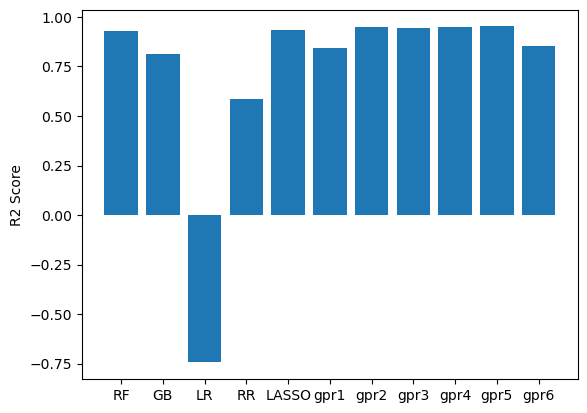

In [15]:
run_models()

## Feature selection


In [16]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
25      X_EA  105.609050
32    X_Rvdw   95.867663
14       X_Z   72.212377
1   mean_A2B   65.395072
4   mean_X2X   45.275813
17       X_G   35.852833
30    A_Rvdw   32.817229
2   mean_A2X   29.382067
18     A_IEI   26.603709
34      B_Ra   22.349002
41      B_Hf   21.695622
11        OF   19.136656
13       B_Z   18.951946
29    A_ChiA   17.090678
7    std_B2X   16.196258
9      E_coh   15.939550
6    std_A2X   13.265442
26    A_ChiP   12.861322
36      B_MP   12.465146
23      A_EA   11.880101
35      A_MP    9.959892
33      B_Rc    9.161701
46     B_CvM    9.044620
31    B_Rvdw    8.706402
40      X_MV    8.579672
38     B_Rho    7.940778
39      B_MV    7.759945
12       A_Z    7.542829
10        TF    6.791751
5    std_A2B    6.754609


In [17]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra', 'B_Hf', 'OF', 'B_Z', 'A_ChiA',
       'std_B2X', 'E_coh', 'std_A2X', 'A_ChiP', 'B_MP', 'A_EA', 'A_MP',
       'B_Rc', 'B_CvM', 'B_Rvdw', 'X_MV', 'B_Rho', 'B_MV', 'A_Z', 'TF',
       'std_A2B', 'A_Kappa', 'std_X2X', 'A_CvM', 'A_B', 'X_Kappa', 'A_G',
       'B_Kappa', 'B_EA', 'B_IEII', 'X_ChiP'], dtype=object)

In [18]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.930444527048912
RMSE:  0.26373371599226364
---------------------------------------
GB
R2:  0.8049288512055588
RMSE:  0.4416685961152788
---------------------------------------
LR
R2:  -0.13978569346289182
RMSE:  1.0676074622551548
---------------------------------------
RR
R2:  0.15553620186602457
RMSE:  0.9189471138939256
---------------------------------------
LASSO
R2:  0.9246856899653456
RMSE:  0.2744345277742113
---------------------------------------
gpr1
R2:  0.5831060356554456
RMSE:  0.6456732643873017
---------------------------------------
gpr2
R2:  0.9490577366574585
RMSE:  0.2257039285048921
---------------------------------------
gpr3
R2:  0.9458753180760754
RMSE:  0.2326471188816329
---------------------------------------
gpr4
R2:  0.9464299112572211
RMSE:  0.23145213056435437
---------------------------------------
gpr5
R2:  0.9542684591991213
RMSE:  0.21384934136180705
---------------------------------------
gpr6
R2:  0.8696254311048381
RMSE:  0.36107418752267

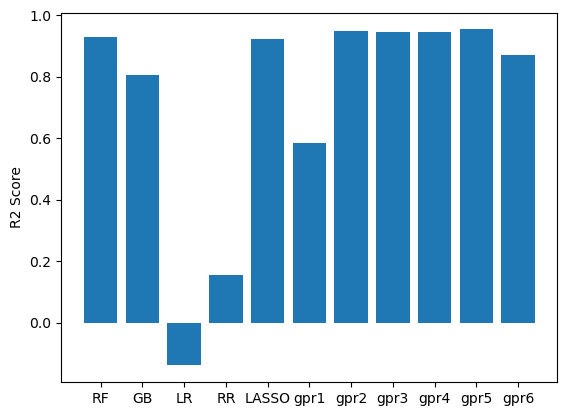

In [19]:
run_models()

In [20]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra', 'B_Hf', 'OF', 'B_Z', 'A_ChiA',
       'std_B2X', 'E_coh', 'std_A2X', 'A_ChiP', 'B_MP', 'A_EA', 'A_MP',
       'B_Rc', 'B_CvM', 'B_Rvdw', 'X_MV', 'B_Rho', 'B_MV', 'A_Z', 'TF',
       'std_A2B'], dtype=object)

In [21]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
t30_columns = ['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra', 'B_Hf', 'OF', 'B_Z', 'A_ChiA',
       'std_B2X', 'E_coh', 'std_A2X', 'A_ChiP', 'B_MP', 'A_EA', 'A_MP',
       'B_Rc', 'B_CvM', 'B_Rvdw', 'X_MV', 'B_Rho', 'B_MV', 'A_Z', 'TF',
       'std_A2B']
data_save=data_std[t30_columns]
#data_save.to_csv("scaled_top_30.csv")

RF
R2:  0.9308801753922998
RMSE:  0.2629064940386603
---------------------------------------
GB
R2:  0.799246070321993
RMSE:  0.4480557216217721
---------------------------------------
LR
R2:  0.7750917269750361
RMSE:  0.47424495044751275
---------------------------------------
RR
R2:  0.7794132009230024
RMSE:  0.469666689341492
---------------------------------------
LASSO
R2:  0.9169121899089738
RMSE:  0.28824956216970415
---------------------------------------
gpr1
R2:  0.8262554041566633
RMSE:  0.41682681756736417
---------------------------------------
gpr2
R2:  0.9342944335204564
RMSE:  0.2563309705820653
---------------------------------------
gpr3
R2:  0.9377292637264963
RMSE:  0.24954105127915058
---------------------------------------
gpr4
R2:  0.9377292664219216
RMSE:  0.24954104587838538
---------------------------------------
gpr5
R2:  0.9485230957873744
RMSE:  0.22688522255234175
---------------------------------------
gpr6
R2:  0.8914330995184896
RMSE:  0.329494917231678

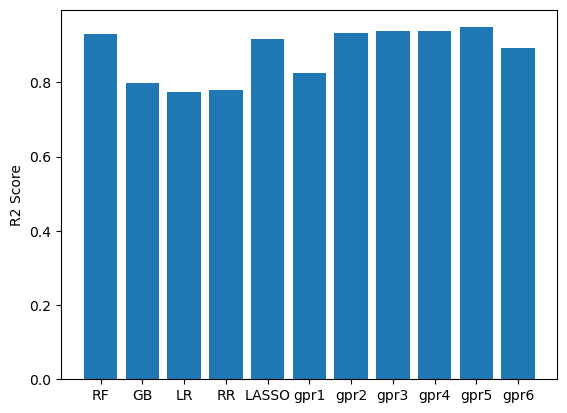

In [22]:
run_models()

In [23]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra', 'B_Hf', 'OF', 'B_Z', 'A_ChiA',
       'std_B2X', 'E_coh', 'std_A2X', 'A_ChiP', 'B_MP', 'A_EA'],
      dtype=object)

In [24]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9166786843870713
RMSE:  0.2886543185419693
---------------------------------------
GB
R2:  0.8040984881796318
RMSE:  0.44260762738611753
---------------------------------------
LR
R2:  0.8938136383750462
RMSE:  0.32586248882765534
---------------------------------------
RR
R2:  0.8943681921239164
RMSE:  0.3250104734867533
---------------------------------------
LASSO
R2:  0.9318949573777837
RMSE:  0.2609694285203082
---------------------------------------
gpr1
R2:  0.9153596421387421
RMSE:  0.290930159765635
---------------------------------------
gpr2
R2:  0.9222377891961235
RMSE:  0.27885876497588613
---------------------------------------
gpr3
R2:  0.8095987635639643
RMSE:  0.436349901381948
---------------------------------------
gpr4
R2:  0.9326106364428388
RMSE:  0.25959461388318744
---------------------------------------
gpr5
R2:  0.9501507562446072
RMSE:  0.2232694420546457
---------------------------------------
gpr6
R2:  0.9173541815980097
RMSE:  0.28748185751798366

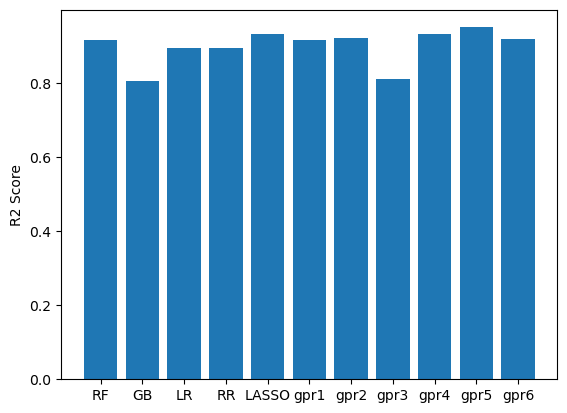

In [25]:
run_models()

In [26]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra'], dtype=object)

In [27]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.9217111152039277
RMSE:  0.2798015096386586
---------------------------------------
GB
R2:  0.7319114840966032
RMSE:  0.5177726488560368
---------------------------------------
LR
R2:  0.8906224170167029
RMSE:  0.33072281896370126
---------------------------------------
RR
R2:  0.8906566547909615
RMSE:  0.3306710528743612
---------------------------------------
LASSO
R2:  0.8976064802349125
RMSE:  0.3199898744727519
---------------------------------------
gpr1
R2:  0.8992331714262006
RMSE:  0.3174379129433019
---------------------------------------
gpr2
R2:  0.9334851918216894
RMSE:  0.25790464939258195
---------------------------------------
gpr3
R2:  0.814318119113258
RMSE:  0.4309082047104023
---------------------------------------
gpr4
R2:  0.8143181007808713
RMSE:  0.43090822598220235
---------------------------------------
gpr5
R2:  0.910428490810571
RMSE:  0.2992849965992767
---------------------------------------
gpr6
R2:  0.9154301362682775
RMSE:  0.29080898151831974


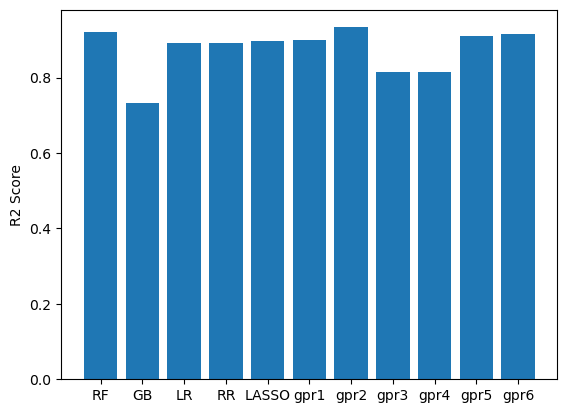

In [28]:
run_models()

# Min-Max scaling

In [29]:
data_std=d.copy()
scalerMM=MinMaxScaler()
scalerMM.fit(np.array(data['ZPE']).reshape(-1, 1))
data_zpe_mm= scalerMM.transform(np.array(data['ZPE']).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std['ZPE'] 
X = data_std.drop(['ZPE'], axis=1)

In [30]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [31]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'A_BP', 'X_BP', 'A_Hf', 'X_MP', 'A_MendeleevNo', 'X_M', 'B_M', 'A_Ra', 'A_MV', 'B_BP', 'B_Hv', 'X_CvM', 'X_ChiA', 'X_B', 'X_MendeleevNo', 'A_M', 'X_Hv', 'X_Ra', 'X_Hf', 'A_Rc', 'A_Hv', 'X_IEII', 'X_Rc'}


In [32]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape
Y = data_std['ZPE'] 
X = data_std.drop(['ZPE'], axis=1)
data_std.to_csv('Coef_a_scaled_non_corr_all.csv',index=False)

In [33]:
X

,density,mean_A2B,mean_A2X,mean_B2X,mean_X2X,std_A2B,std_A2X,std_B2X,std_X2X,E_coh,...,X_MV,B_Hf,A_Kappa,B_Kappa,X_Kappa,A_CvM,B_CvM,A_B,B_B,B_MendeleevNo
0,0.672824,0.151484,0.474179,0.702269,0.436373,0.244175,9.343893e-01,5.352915e-01,1.000000e+00,0.000000,...,0.424242,0.070857,1.000000,0.024634,0.034592,0.222415,0.000000,0.333333,0.5,0.872093
1,0.656093,0.282161,0.440717,0.147937,0.098232,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.637222,...,0.424242,0.211538,0.022523,0.071527,0.034592,0.021720,0.006358,0.000000,1.0,0.441860
2,0.342848,0.220005,0.393242,0.102269,0.028852,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.828107,...,0.000000,0.000000,0.022523,0.265350,0.036783,0.021720,1.000000,0.000000,0.0,0.000000
3,0.211416,0.210569,0.386035,0.095336,0.018319,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.947251,...,0.015152,0.000000,0.022523,0.265350,0.335746,0.021720,1.000000,0.000000,0.0,0.000000
4,0.311994,0.308379,0.413366,0.495881,0.314245,0.058901,1.042090e-01,6.791391e-01,6.494415e-01,0.774473,...,0.424242,0.032255,0.022523,0.001250,0.034592,0.021720,0.057514,0.000000,0.5,0.941860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.571421,0.187725,0.000000,0.436563,0.042631,0.000000,9.518058e-02,1.121353e-01,1.164861e-01,0.715171,...,0.424242,0.015507,0.040541,0.109041,0.034592,0.114393,0.002312,0.666667,0.5,0.813953
76,0.722624,0.095381,0.450072,0.644358,0.203585,0.051856,6.635480e-01,6.759343e-01,6.334441e-01,0.766663,...,0.424242,0.157343,0.148649,0.293485,0.034592,0.000000,0.094509,0.333333,1.0,0.523256
77,0.488903,0.371390,0.396239,0.000000,0.015566,0.000000,4.234665e-12,2.820945e-12,2.216963e-12,0.893497,...,0.424242,0.041608,0.148649,0.001029,0.034592,0.000000,0.026590,0.333333,0.5,0.988372
78,0.388461,0.060573,0.438923,0.626034,0.261590,0.055900,6.836622e-01,6.365767e-01,7.387098e-01,0.654047,...,0.424242,0.161713,0.018018,0.096536,0.034592,0.048943,0.106069,0.666667,1.0,0.488372


### Using CV technique

RF
R2:  0.9240741664278657
RMSE:  0.06601215859173608
---------------------------------------
GB
R2:  0.825871932004695
RMSE:  0.09996858403589085
---------------------------------------
LR
R2:  -1.0892203433787273
RMSE:  0.3462751077481117
---------------------------------------
RR
R2:  0.8970665863262259
RMSE:  0.07686123139358275
---------------------------------------
LASSO
R2:  0.7740079837927297
RMSE:  0.11388740527894517
---------------------------------------
gpr1
R2:  0.6731971085803119
RMSE:  0.13695317191753983
---------------------------------------
gpr2
R2:  0.9363515364891573
RMSE:  0.060439813022476536
---------------------------------------
gpr3
R2:  0.9328667457193455
RMSE:  0.06207232319168453
---------------------------------------
gpr4
R2:  0.9328667618487625
RMSE:  0.06207231573494453
---------------------------------------
gpr5
R2:  0.9539728536140877
RMSE:  0.0513968112136369
---------------------------------------
gpr6
R2:  0.8922759646272995
RMSE:  0.0786294896

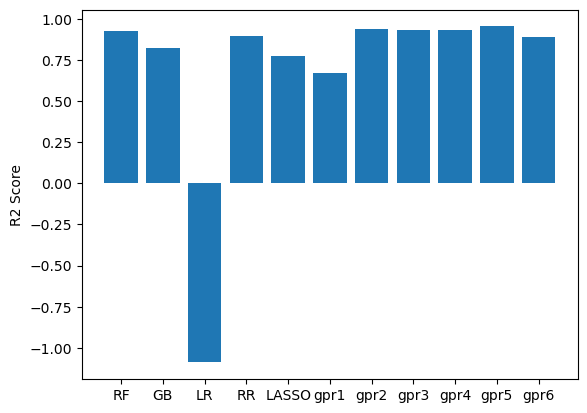

In [34]:
run_models()

## Feature selection


In [35]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
25      X_EA  105.609050
32    X_Rvdw   95.867663
14       X_Z   72.212377
1   mean_A2B   65.395072
4   mean_X2X   45.275813
17       X_G   35.852833
30    A_Rvdw   32.817229
2   mean_A2X   29.382067
18     A_IEI   26.603709
34      B_Ra   22.349002
41      B_Hf   21.695622
11        OF   19.136656
13       B_Z   18.951946
29    A_ChiA   17.090678
7    std_B2X   16.196258
9      E_coh   15.939550
6    std_A2X   13.265442
26    A_ChiP   12.861322
36      B_MP   12.465146
23      A_EA   11.880101
35      A_MP    9.959892
33      B_Rc    9.161701
46     B_CvM    9.044620
31    B_Rvdw    8.706402
40      X_MV    8.579672
38     B_Rho    7.940778
39      B_MV    7.759945
12       A_Z    7.542829
10        TF    6.791751
5    std_A2B    6.754609


In [36]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra', 'B_Hf', 'OF', 'B_Z', 'A_ChiA',
       'std_B2X', 'E_coh', 'std_A2X', 'A_ChiP', 'B_MP', 'A_EA', 'A_MP',
       'B_Rc', 'B_CvM', 'B_Rvdw', 'X_MV', 'B_Rho', 'B_MV', 'A_Z', 'TF',
       'std_A2B', 'A_Kappa', 'std_X2X', 'A_CvM', 'A_B', 'X_Kappa', 'A_G',
       'B_Kappa', 'B_EA', 'B_IEII', 'X_ChiP'], dtype=object)

In [37]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9279531913538037
RMSE:  0.06430378313464229
---------------------------------------
GB
R2:  0.8072465002026484
RMSE:  0.10517930243140687
---------------------------------------
LR
R2:  -0.1397856934628725
RMSE:  0.2557647864085241
---------------------------------------
RR
R2:  0.769884957764042
RMSE:  0.1149215975035965
---------------------------------------
LASSO
R2:  0.7740142949064017
RMSE:  0.11388581504272645
---------------------------------------
gpr1
R2:  0.27885374884756264
RMSE:  0.20344209766963378
---------------------------------------
gpr2
R2:  0.9327581432895848
RMSE:  0.06212251054710632
---------------------------------------
gpr3
R2:  0.9312141622141317
RMSE:  0.06283167906992355
---------------------------------------
gpr4
R2:  0.9312141586942675
RMSE:  0.06283168067751443
---------------------------------------
gpr5
R2:  0.9520989190312156
RMSE:  0.052432649898153307
---------------------------------------
gpr6
R2:  0.9009561007616341
RMSE:  0.075395081

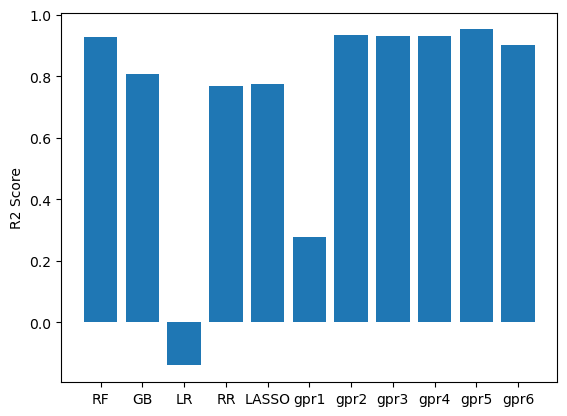

In [38]:
run_models()

In [39]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra', 'B_Hf', 'OF', 'B_Z', 'A_ChiA',
       'std_B2X', 'E_coh', 'std_A2X', 'A_ChiP', 'B_MP', 'A_EA', 'A_MP',
       'B_Rc', 'B_CvM', 'B_Rvdw', 'X_MV', 'B_Rho', 'B_MV', 'A_Z', 'TF',
       'std_A2B'], dtype=object)

In [40]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9260171190958264
RMSE:  0.06516205460452779
---------------------------------------
GB
R2:  0.7702965840046545
RMSE:  0.11481876650626775
---------------------------------------
LR
R2:  0.7750917269750363
RMSE:  0.11361400397137826
---------------------------------------
RR
R2:  0.8422771287095292
RMSE:  0.09514292247715239
---------------------------------------
LASSO
R2:  0.7740142949064017
RMSE:  0.11388581504272645
---------------------------------------
gpr1
R2:  0.7971635361068717
RMSE:  0.10789521019839002
---------------------------------------
gpr2
R2:  0.9250164877610416
RMSE:  0.06560123864425156
---------------------------------------
gpr3
R2:  0.9283982365423088
RMSE:  0.06410486786320477
---------------------------------------
gpr4
R2:  0.9283982388980573
RMSE:  0.0641048668086571
---------------------------------------
gpr5
R2:  0.9528560760734117
RMSE:  0.052016606231935984
---------------------------------------
gpr6
R2:  0.9181303503148706
RMSE:  0.068547341

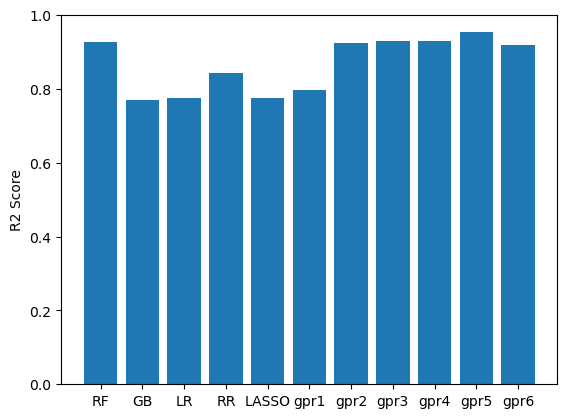

In [41]:
run_models()

In [42]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra', 'B_Hf', 'OF', 'B_Z', 'A_ChiA',
       'std_B2X', 'E_coh', 'std_A2X', 'A_ChiP', 'B_MP', 'A_EA'],
      dtype=object)

In [43]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8999081443368742
RMSE:  0.07579289932192951
---------------------------------------
GB
R2:  0.7556209399346135
RMSE:  0.11842984069672687
---------------------------------------
LR
R2:  0.8938136383750462
RMSE:  0.07806628634601755
---------------------------------------
RR
R2:  0.9052487593848767
RMSE:  0.07374313602097936
---------------------------------------
LASSO
R2:  0.7741265277684781
RMSE:  0.11385753157601075
---------------------------------------
gpr1
R2:  0.9017842534083576
RMSE:  0.07507921293518714
---------------------------------------
gpr2
R2:  0.9007571616461554
RMSE:  0.07547076260025752
---------------------------------------
gpr3
R2:  0.900449828426723
RMSE:  0.07558753043650658
---------------------------------------
gpr4
R2:  0.9004498060159458
RMSE:  0.07558753894465471
---------------------------------------
gpr5
R2:  0.9391898757911463
RMSE:  0.05907681800467815
---------------------------------------
gpr6
R2:  0.9189392574928503
RMSE:  0.0682078623

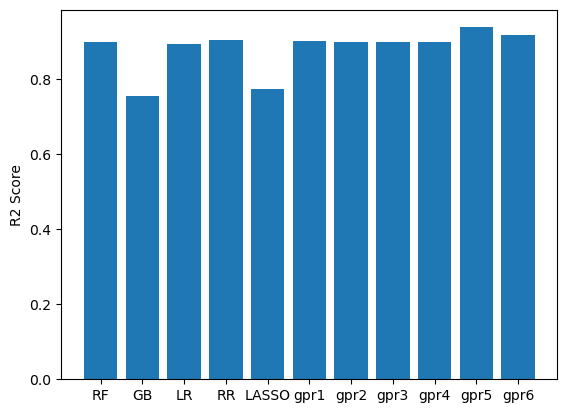

In [44]:
run_models()

In [45]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'mean_X2X', 'X_G', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'B_Ra'], dtype=object)

In [46]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.9206413873154615
RMSE:  0.06748794180750255
---------------------------------------
GB
R2:  0.726979318310027
RMSE:  0.12517768725587172
---------------------------------------
LR
R2:  0.890622417016703
RMSE:  0.0792306668351674
---------------------------------------
RR
R2:  0.891321772643263
RMSE:  0.07897696187847902
---------------------------------------
LASSO
R2:  0.7604347470823963
RMSE:  0.11725761694768855
---------------------------------------
gpr1
R2:  0.8907846178175387
RMSE:  0.07917189772897985
---------------------------------------
gpr2
R2:  0.9285804019374345
RMSE:  0.0640232698346003
---------------------------------------
gpr3
R2:  0.7564670843468533
RMSE:  0.1182246356358712
---------------------------------------
gpr4
R2:  0.756467090426848
RMSE:  0.11822463416008472
---------------------------------------
gpr5
R2:  0.9028264989695577
RMSE:  0.07467978777245074
---------------------------------------
gpr6
R2:  0.9099616676341897
RMSE:  0.0718857604615548

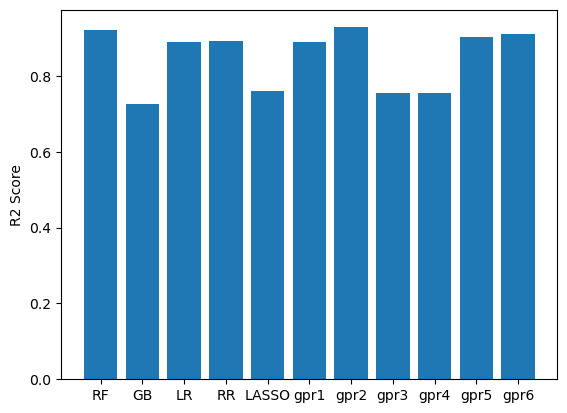

In [47]:
run_models()